In [ ]:
# 베이지안 최적화 사용하려면 먼저 pip install 진행
# !pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=a26e04488b07e3d84602b3b2927b7271d713d1da2526a6cff3a0550c3d253123
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [49]:
# from bayes_opt import BayesianOptimization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, PReLU
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import tensorflow as tf


# train data load
train_err = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/train_err_data.csv')
train_quality = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/train_quality_data.csv')
train_problem = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/train_problem_data.csv')

# test data load
test_err = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/test_err_data.csv')
test_quality = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/test_quality_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
print(f'train_err의 고유 user_id는 {len(train_err.user_id.unique())}개 입니다')
print(f'train_quality의 고유 user_id는 {len(train_quality.user_id.unique())}개 입니다')
print(f'train_problem의 고유 user_id는 {len(train_problem.user_id.unique())}개 입니다')
print()
print(f'test_err의 고유 user_id는 {len(test_err.user_id.unique())}개 입니다')
print(f'test_quality의 고유 user_id는 {len(test_quality.user_id.unique())}개 입니다')

train_err의 고유 user_id는 15000개 입니다
train_quality의 고유 user_id는 8281개 입니다
train_problem의 고유 user_id는 5000개 입니다

test_err의 고유 user_id는 14998개 입니다
test_quality의 고유 user_id는 8268개 입니다


# train_err 파일

In [51]:
# train_err의 정보 확인
# train_err는 user_id, timie, model_nm, fwver, errtype, errcode 컬럼이 존재
# model_nm, fwver, errcode는 각각 object 형태
print(train_err.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      int64 
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(3), object(3)
memory usage: 757.8+ MB
None


In [52]:
# train_err의 결측치 확인
print(train_err.isnull().sum())

# 확인결과 결측치는 errcode 컬럼에서 단 한개
# 해당 행과 앞뒤 행까지 확인
null_index = train_err.index[train_err['errcode'].isna()][0]
display(train_err.iloc[null_index-1:null_index+2, :])

user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     1
dtype: int64


,user_id,time,model_nm,fwver,errtype,errcode
3825743,13639,20201121174110,model_2,04.33.1261,31,0
3825744,13639,20201121191718,model_2,04.33.1261,5,NaN
3825745,13639,20201121191718,model_2,04.33.1261,5,40013


In [53]:
# 16554663개 중에 1개 행렬이므로 해당 행 제거
# train_err = train_err.dropna()

# 혹은 바로 다음 행과 컬럼 배열이 동일하므로 40013으로 대체
train_err = train_err.fillna(40013)

In [54]:
# train_err의 각 컬럼간의 교차 분석
# user_id, time은 우선적으로 제외하고
# model_nm, fwver, errtype, errcode로 분석 진행
# 비식별 데이터지만 컬럼 이름으로 유추컨대
# model_nm - 모델 이름, fwver - 펌웨어 버전, errtype - 에러타입, errcode - 에러 코드라 추정해 볼 수 있음
                              # 펌웨어란 하드웨어의 제어(low-level control)와 구동을 담당하는 일종의 운영체제
# 추정이 맞다면 위 컬럼들은 범주형 변수에 해당

columns = ['model_nm','fwver','errtype','errcode']

for column in columns:
    print(f'{column}의 최빈값은 {train_err[column].mode()[0]}입니다.')

model_nm의 최빈값은 model_1입니다.
fwver의 최빈값은 04.16.3553입니다.
errtype의 최빈값은 23입니다.
errcode의 최빈값은 1입니다.


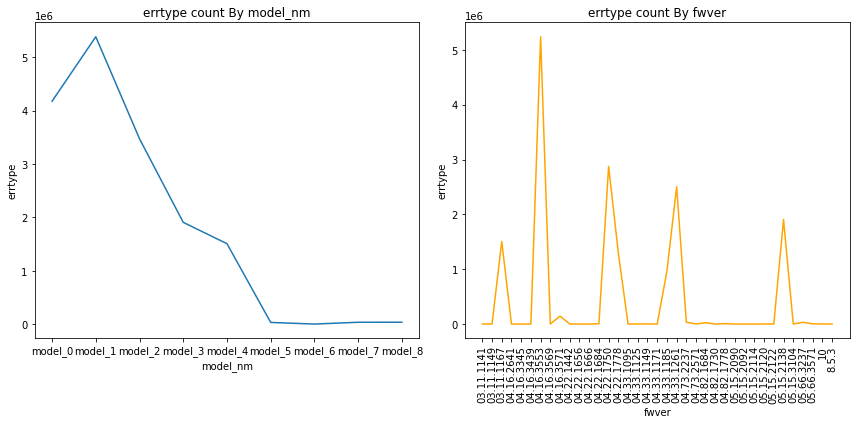

In [55]:
# 시각화
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.plot(train_err.groupby(train_err['model_nm'])['errtype'].count())
ax1.title.set_text('errtype count By model_nm')
ax1.set_xlabel('model_nm')
ax1.set_ylabel('errtype')

ax2 = plt.subplot(122)
ax2.plot(train_err.groupby(train_err['fwver'])['errtype'].count(), color='orange')
ax2.title.set_text('errtype count By fwver')
ax2.set_xlabel('fwver')
ax2.set_ylabel('errtype')
plt.xticks(rotation=90)
fig.tight_layout()

plt.show()

# model_nm, fwver 각각의 최빈값인 model_1, 04.16.3553에서
# 가장 많은 수의 errtype count가 나왔고
# model_nm의 경우, model_1, model_0, model_2 순으로 errtype count가 높으며
# model_1일 때를 제외하고 model 넘버가 높아질수록 errtype count가 감소
# fwver의 경우, 04.16.3553, 03.11.1167 등을 비롯한 특정 fwver 5개에서
# 유독 높은 errtype count를 확인할 수 있음

In [56]:
#카이제곱검정을 통한 독립성 검정

# 교차표 생성 및 카이제곱검정
for first_column in columns:
    for second_column in columns:
        # 비교군이 같은 경우 continue
        if first_column == second_column:
            continue
        else:
            result = pd.crosstab(train_err[first_column], train_err[second_column])
            print(f'{first_column}과 {second_column}의 p-value는 {stats.chi2_contingency(observed=result)[1]}입니다')

model_nm과 fwver의 p-value는 0.0입니다
model_nm과 errtype의 p-value는 0.0입니다
model_nm과 errcode의 p-value는 0.0입니다
fwver과 model_nm의 p-value는 0.0입니다
fwver과 errtype의 p-value는 0.0입니다
fwver과 errcode의 p-value는 0.0입니다
errtype과 model_nm의 p-value는 0.0입니다
errtype과 fwver의 p-value는 0.0입니다
errtype과 errcode의 p-value는 0.0입니다
errcode과 model_nm의 p-value는 0.0입니다
errcode과 fwver의 p-value는 0.0입니다
errcode과 errtype의 p-value는 0.0입니다


In [9]:
# 독립성 검정 결과로 나온
# 모든 두 컬럼들 사이의 p-value는 0.0으로 유의수준 0.05하에서 귀무가설 기각
# 따라서, 모든 두 컬럼들 사이에는 관련성이 존재

# train_quality 파일

In [57]:
# train_quality의 정보 확인
# train_err는 timie, user_id, fwver, quality_0 ~ quality_12 컬럼이 존재
# fwver, quality_5,7,8,9,10은 각각 object 형태
train_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       788544 non-null  object 
 3   quality_0   684192 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   788511 non-null  float64
 6   quality_3   828624 non-null  int64  
 7   quality_4   828624 non-null  int64  
 8   quality_5   828604 non-null  object 
 9   quality_6   828624 non-null  int64  
 10  quality_7   828624 non-null  object 
 11  quality_8   828624 non-null  object 
 12  quality_9   828624 non-null  object 
 13  quality_10  828624 non-null  object 
 14  quality_11  828624 non-null  int64  
 15  quality_12  828624 non-null  int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 101.2+ MB


In [58]:
print(f'train_err의 고유 user_id는 {len(train_err.user_id.unique())}개 입니다')
print(f'train_quality의 고유 user_id는 {len(train_quality.user_id.unique())}개 입니다')
print(f'train_problem의 고유 user_id는 {len(train_problem.user_id.unique())}개 입니다')

train_err의 고유 user_id는 15000개 입니다
train_quality의 고유 user_id는 8281개 입니다
train_problem의 고유 user_id는 5000개 입니다


In [59]:
# train_problem에 한번이라도 나와 있는 유저는
# 시스템 풀질에 불편을 느꼈다고 할때

quality_user = train_quality.user_id.unique()
problem_user = train_problem.user_id.unique()
quality_problem_user = [x for x in quality_user if x in problem_user]
print(f'quality_user {len(quality_user)}명 중 불편을 느낀 user의 수는 {len(quality_problem_user)}명 입니다.')

# 따라서, quality_user 8281명 중 3167명은 불편을 느낌.

quality_user 8281명 중 불편을 느낀 user의 수는 3167명 입니다.


In [60]:
# object형태인 quality_5,7,8,9,10은
# 확인결과 숫자가 천단위로 넘어가면 ',' 가 붙기 때문에 object.
# 특이한 점은 quality_8의 경우, 
# 같은 수라도 어떤 값은 int, 어떤 값은 str로 표현. ex) 0, '0'
# 또한, quality_3, quality_4는 모두 0으로 버려도 무방

# string형태를 int로 바꿀 함수 정의
def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        pass
    else:
        return int(x)

In [61]:
# ','등 불필요한 문자열이 들어가 있어 object로 읽히던 컬럼들을 string2num 함수를 통해 int 형태로 변환

for i in tqdm(range(13)):
    quality = 'quality_' + str(i)
    train_quality[quality] = train_quality[quality].apply(string2num)

100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


In [64]:
# object 형태인 fwver은 최빈값으로 대체
# int 또는 float 형태인 quality_0, quality_1, quality_2는 평균값으로 결측값 대체

train_quality['fwver'] = train_quality['fwver'].fillna(train_quality['fwver'].mode()[0])
train_quality['quality_0'] = train_quality['quality_0'].fillna(train_quality['quality_0'].mean())
train_quality['quality_1'] = train_quality['quality_1'].fillna(train_quality['quality_1'].mean())
train_quality['quality_2'] = train_quality['quality_2'].fillna(train_quality['quality_2'].mean())
train_quality['quality_5'] = train_quality['quality_5'].fillna(train_quality['quality_5'].mean())

In [ ]:
# 결측치를 ffill 방법으로 대체할 경우
train_quality = train_quality.fillna('ffill')

# ffill로 변경하면 연달아 na값을 경우 'ffill'로 채워지면서 object가 됨
# 따라서, 'ffill'로 채워진 부분을 수정해주고 넘어가야 함. -> 최빈값으로 대체
train_quality.loc[train_quality['quality_0'] == 'ffill','quality_0'] = train_quality['quality_0'].mode()[0]
train_quality.loc[train_quality['quality_2'] == 'ffill','quality_2'] = train_quality['quality_2'].mode()[0]
train_quality.loc[train_quality['quality_5'] == 'ffill','quality_5'] = train_quality['quality_5'].mode()[0]

# 기존 형태였던 float64로 변경
train_quality['quality_0'] = train_quality['quality_0'].astype(np.float64)
train_quality['quality_2'] = train_quality['quality_2'].astype(np.float64)
train_quality['quality_5'] = train_quality['quality_5'].astype(np.float64)
train_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       828624 non-null  object 
 3   quality_0   828624 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   828624 non-null  float64
 6   quality_5   828624 non-null  float64
 7   quality_6   828624 non-null  int64  
 8   quality_7   828624 non-null  int64  
 9   quality_8   828624 non-null  int64  
 10  quality_9   828624 non-null  int64  
 11  quality_10  828624 non-null  int64  
 12  quality_11  828624 non-null  int64  
 13  quality_12  828624 non-null  int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 88.5+ MB


In [65]:
# quality_3, quality_4는 영행렬이므로 drop
train_quality = train_quality.drop(['quality_3','quality_4'], axis=1)
# 각 컬럼간의 상관관계
corr = train_quality.corr().astype('float64')
display(corr)

,time,user_id,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
time,1.000000,-0.001218,-0.002967,0.002777,-0.002052,0.002550,-0.012724,-0.015707,0.003519,-0.004334,0.004219,0.002685,0.026708
user_id,-0.001218,1.000000,0.006085,0.007723,0.003407,-0.002754,-0.017417,-0.021609,0.004222,0.007148,-0.004560,0.010079,0.019467
quality_0,-0.002967,0.006085,1.000000,-0.001992,0.761589,0.066808,-0.000284,0.000618,-0.000224,0.450549,0.032167,-0.001927,0.005503
quality_1,0.002777,0.007723,-0.001992,1.000000,-0.001443,-0.007016,-0.007767,-0.015169,0.627764,0.000787,-0.000853,0.550380,0.010572
quality_2,-0.002052,0.003407,0.761589,-0.001443,1.000000,0.068890,0.000985,0.000607,-0.000178,0.477998,0.029344,-0.000854,0.004987
quality_5,0.002550,-0.002754,0.066808,-0.007016,0.068890,1.000000,0.007948,0.009067,0.000228,0.037117,0.604239,-0.006520,0.037743
quality_6,-0.012724,-0.017417,-0.000284,-0.007767,0.000985,0.007948,1.000000,0.810488,0.000812,0.001117,0.012151,-0.020196,-0.006204
quality_7,-0.015707,-0.021609,0.000618,-0.015169,0.000607,0.009067,0.810488,1.000000,0.000982,0.001351,0.015014,-0.027924,-0.007758
quality_8,0.003519,0.004222,-0.000224,0.627764,-0.000178,0.000228,0.000812,0.000982,1.000000,-0.000389,0.000378,0.002014,0.010314
quality_9,-0.004334,0.007148,0.450549,0.000787,0.477998,0.037117,0.001117,0.001351,-0.000389,1.000000,0.061430,0.002465,0.010548


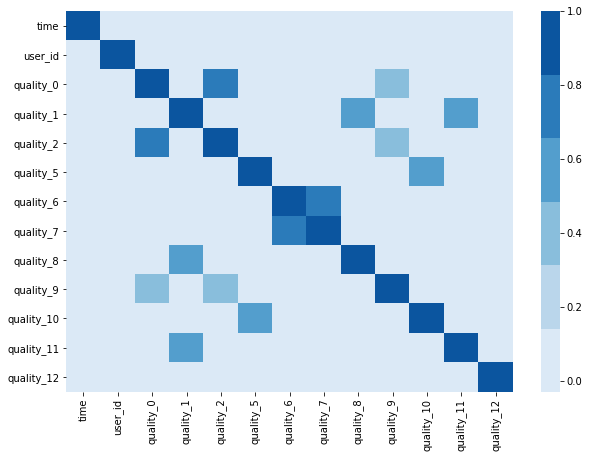

In [66]:
# 상관관계 시각화
cmap = sns.color_palette("Blues")
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, cmap=cmap)

In [18]:
# quality가 어떤 변수인지는 모르겠으나
# 일단 fwv가 범주형 변수이므로 카이제곱검정을 시행해 보았음.
# 이 결과, 0으로만 이뤄진 quality_3, quality_4를 제외하고
# quality_5는 fwv와 독립.

for i in range(13):
    if i == 3 or i == 4:
        continue
    quality = 'quality_' + str(i)
    result = pd.crosstab(train_quality.fwver, train_quality[quality])
    p_value = stats.chi2_contingency(observed=result)[1]
    print(f'fwver와 quality_{i} 사이의 p_value값은 {p_value}입니다.')

fwver와 quality_0 사이의 p_value값은 0.0입니다.
fwver와 quality_1 사이의 p_value값은 0.0입니다.
fwver와 quality_2 사이의 p_value값은 0.0입니다.
fwver와 quality_5 사이의 p_value값은 1.0입니다.
fwver와 quality_6 사이의 p_value값은 0.0입니다.
fwver와 quality_7 사이의 p_value값은 0.0입니다.
fwver와 quality_8 사이의 p_value값은 0.0입니다.
fwver와 quality_9 사이의 p_value값은 0.0입니다.
fwver와 quality_10 사이의 p_value값은 0.0입니다.
fwver와 quality_11 사이의 p_value값은 0.0입니다.
fwver와 quality_12 사이의 p_value값은 0.0입니다.


In [ ]:
# 향후, quality에서 전처리가 된다면
# fwv와의 카이제곱검정은 재진행이 필요
# 또한 quality간의 corr()를 통해
# 상관관계 분석도 해볼 수 있을 듯

# Preprocessing

In [67]:
# 데이콘 베이스라인 Modeling
# errtype counts를 변수로 problem에서 
# 한 번이라도 user_id가 나오면 오류가 발생했다고 설정

train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

id_error = train_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42))

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min,err - 1] += 1
error.shape

# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem = np.zeros(15000)
problem[train_problem.user_id.unique()-10000] = 1 
problem.shape

# X = error
Y = problem

100%|██████████| 16554663/16554663 [00:40<00:00, 412078.88it/s]


In [68]:
train_quality['quality_0_2'] = abs(train_quality['quality_0'] - train_quality['quality_2'])
train_quality['quality_0_9'] = abs(train_quality['quality_0'] - train_quality['quality_9'])
train_quality['quality_1_8'] = abs(train_quality['quality_1'] - train_quality['quality_8'])
train_quality['quality_1_11'] = abs(train_quality['quality_1'] - train_quality['quality_11'])
train_quality['quality_2_9'] = abs(train_quality['quality_2'] - train_quality['quality_9'])
train_quality['quality_5_10'] = abs(train_quality['quality_5'] - train_quality['quality_10'])
train_quality['quality_6_7'] = abs(train_quality['quality_6'] - train_quality['quality_7'])

In [69]:
# train_quality 데이터 또한 위와 동일한 방법으로 처리
# 단, quality값의 총합을 변수로 생성

id_quality = train_quality[['user_id','quality_0','quality_1','quality_2','quality_5','quality_6',
                            'quality_7','quality_8','quality_9','quality_10','quality_11','quality_12',
                            'quality_0_2','quality_0_9','quality_1_8','quality_1_11','quality_2_9','quality_5_10','quality_6_7']].values

quality = np.zeros((train_user_number,18))

# ffill등의 방식으로 결측치를 처리하면 float64형태인 컬럼으로 인해 
# id_quality 또한 float64형태로 바뀌면서 인덱싱에 문제가 생김
# 따라서, person_idx에 int()를 씌워주면서 값 대입

# for person_idx, q0, q1, q2, q5, q6, q7, q8, q9, q10, q11, q12 in tqdm(id_quality):
for person_idx, q0, q1, q2, q5, q6, q7, q8, q9, q10, q11, q12, q0_2, q0_9, q1_8, q1_11, q2_9, q5_10, q6_7 in tqdm(id_quality):

    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    if q0 != 0 :
        quality[int(person_idx) - train_user_id_min, 0] += q0
    if q1 != 0 :
        quality[int(person_idx) - train_user_id_min, 1] += q1
    if q2 != 0 :
        quality[int(person_idx) - train_user_id_min, 2] += q2
    if q5 != 0 :
        quality[int(person_idx) - train_user_id_min, 3] += q5
    if q6 != 0 :
        quality[int(person_idx) - train_user_id_min, 4] += q6
    if q7 != 0 :
        quality[int(person_idx) - train_user_id_min, 5] += q7
    if q8 != 0 :
        quality[int(person_idx) - train_user_id_min, 6] += q8
    if q9 != 0 :
        quality[int(person_idx) - train_user_id_min, 7] += q9
    if q10 != 0 :
        quality[int(person_idx) - train_user_id_min, 8] += q10
    if q11 != 0 :
        quality[int(person_idx) - train_user_id_min, 9] += q11
    if q12 != 0 :
        quality[int(person_idx) - train_user_id_min, 10] += q12

    if q0_2 != 0 :
        quality[int(person_idx) - train_user_id_min, 11] += q0_2
    if q0_9 != 0 :
        quality[int(person_idx) - train_user_id_min, 12] += q0_9
    if q1_8 != 0 :
        quality[int(person_idx) - train_user_id_min, 13] += q1_8
    if q1_11 != 0 :
        quality[int(person_idx) - train_user_id_min, 14] += q1_11
    if q2_9 != 0 :
        quality[int(person_idx) - train_user_id_min, 15] += q2_9
    if q5_10 != 0 :
        quality[int(person_idx) - train_user_id_min, 16] += q5_10
    if q6_7 != 0 :
        quality[int(person_idx) - train_user_id_min, 17] += q6_7

100%|██████████| 828624/828624 [00:08<00:00, 98935.02it/s]


In [96]:
# 위에서 만든 error와 quality를 concatenate
X = np.concatenate((error, quality), axis = 1)
Y = problem

In [102]:
# train_err의 fwver, model_nm을 변수로 사용할 경우
# 각 user_id에서 최빈값의 fwver, model_nm을 추출

fwv = []
for i in tqdm(range(train_user_id_min, train_user_id_max+1)):
    fwv.append(train_err[train_err['user_id'] == i].fwver.mode()[0])

fwv = np.array(fwv)

model = []
for i in tqdm(range(train_user_id_min, train_user_id_max+1)):
    model.append(train_err[train_err['user_id'] == i].model_nm.mode()[0])

model = np.array(model)

# 위에서 만든 error array와
# fwv, model을 concat하기 위해 각각 DF, Series로 변경
# error_df = pd.DataFrame(X)

# fwv_series = pd.Series(fwv,name='fwv')
# model_series = pd.Series(model,name='model')

# # fwv, model concat
# error_df = pd.concat([error_df,fwv_series], axis=1)
# error_df = pd.concat([error_df,model_series], axis=1)
# error_df.head()

##(시도) errtype count가 1000개도 안되는 컬럼들을 drop
# error_df = error_df.drop([7,8,18,20,29], axis=1)
# error_df

# fwv, model 컬럼 안의 값들의
# 관계성을 주지 않기 위해 가변수화
# X = pd.get_dummies(error_df)

100%|██████████| 15000/15000 [02:51<00:00, 87.58it/s]


In [109]:
X = pd.get_dummies(error_df)
X = X.values

In [107]:
error_df = pd.DataFrame(X)
error_df = pd.concat([error_df,fwv_series], axis=1)
error_df = pd.concat([error_df,model_series], axis=1)
error_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,fwv,model
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0,0.0,05.15.2138,model_3
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,04.33.1261,model_2
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,2.0,30.0,33.0,48.0,552.0,0.0,12.0,372.0,2.0,0.0,10.0,50.0,2.0,0.0,40.0,339.0,508.0,05.15.2138,model_3
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,04.33.1261,model_2
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,20.0,2.0,20.0,6.0,89.0,1044.0,0.0,0.0,48.0,2.0,0.0,0.0,20.0,2.0,0.0,20.0,42.0,959.0,04.22.1750,model_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,100.0,10.0,100.0,15.0,10.0,0.0,0.0,0.0,60.0,10.0,0.0,0.0,100.0,10.0,0.0,100.0,45.0,10.0,04.33.1261,model_2
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,05.15.2138,model_3
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,40.0,4.0,40.0,23.0,4.0,0.0,0.0,0.0,228.0,4.0,0.0,0.0,40.0,4.0,0.0,40.0,205.0,4.0,04.22.1750,model_0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,14.0,0.0,15.0,12.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,04.22.1778,model_0


In [78]:
# 이상치 처리(이건 나중에 고칠 필요가 있음)
# zscore 바깥의 값들을 이상치로 보고 평균값으로 대체

zscore = 1.8
for col in error_df.columns:
    outliers = error_df[col][np.abs(stats.zscore(error_df[col])) > zscore]
    col_mean = np.mean(error_df.loc[~error_df[col].isin(outliers), col])
    error_df.loc[error_df[col].isin(outliers), col] = col_mean

In [ ]:
# Normalization

# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# scaler.fit(X)
# X = scaler.transform(X)

In [ ]:
# train_test_split
# K-Fold를 할 경우 하지 않고 skip
x_train, x_val, y_train, y_val = \
train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
x_train.shape

In [ ]:
# TestSet

test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

test_err = test_err.dropna()

id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
# test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

In [ ]:
# ,가 들어가 있어 object로 읽히던 컬럼들을 string2num 함수를 통해
# int 형태로 변환

# ','등 불필요한 문자열이 들어가 있어 object로 읽히던 컬럼들을 string2num 함수를 통해 int 형태로 변환

for i in tqdm(range(13)):
    quality = 'quality_' + str(i)
    test_quality[quality] = test_quality[quality].apply(string2num)

In [ ]:
test_quality.isnull().sum()

In [ ]:
# # object 형태인 fwver은 최빈값으로
# # int 또는 float 형태인 quality_0, quality_1, quality_2, ... 는 평균값으로 결측값 대체

test_quality['fwver'] = test_quality['fwver'].fillna(test_quality['fwver'].mode()[0])
test_quality['quality_0'] = test_quality['quality_0'].fillna(test_quality['quality_0'].mean())
test_quality['quality_1'] = test_quality['quality_1'].fillna(test_quality['quality_1'].mean())
test_quality['quality_2'] = test_quality['quality_2'].fillna(test_quality['quality_2'].mean())
test_quality['quality_5'] = test_quality['quality_5'].fillna(test_quality['quality_5'].mean())
test_quality['quality_6'] = test_quality['quality_6'].fillna(test_quality['quality_6'].mean())

In [ ]:
# trainset에서 행한 방식과 동일하게 train_quality 처리

id_quality = test_quality[['user_id','quality_0','quality_1','quality_2','quality_5','quality_6','quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']].values
quality = np.zeros((test_user_number,11))

for person_idx, q0, q1, q2, q5, q6, q7, q8, q9, q10, q11,q12 in tqdm(id_quality):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    if q0 != 0 :
        quality[int(person_idx) - test_user_id_min, 0] += q0
    if q1 != 0 :
        quality[int(person_idx) - test_user_id_min, 1] += q1
    if q2 != 0 :
        quality[int(person_idx) - test_user_id_min, 2] += q2
    if q5 != 0 :
        quality[int(person_idx) - test_user_id_min, 3] += q5
    if q6 != 0 :
        quality[int(person_idx) - test_user_id_min, 4] += q6
    if q7 != 0 :
        quality[int(person_idx) - test_user_id_min, 5] += q7
    if q8 != 0 :
        quality[int(person_idx) - test_user_id_min, 6] += q8
    if q9 != 0 :
        quality[int(person_idx) - test_user_id_min, 7] += q9
    if q10 != 0 :
        quality[int(person_idx) - test_user_id_min, 8] += q10
    if q11 != 0 :
        quality[int(person_idx) - test_user_id_min, 9] += q11
    if q12 != 0 :
        quality[int(person_idx) - test_user_id_min, 10] += q12

In [ ]:
# 위에서 만든 test_x와 quality를 concatenate
X_test = np.concatenate((test_x, quality), axis = 1)
X_test.shape

In [ ]:
# TestSet 이상치 처리 및 가변수화, 정규화

test_df = pd.DataFrame(X_test)

zscore = 1.8
for col in test_df.columns:
    outliers = test_df[col][np.abs(stats.zscore(test_df[col])) > zscore]
    col_mean = np.mean(test_df.loc[~test_df[col].isin(outliers), col])
    test_df.loc[test_df[col].isin(outliers), col] = col_mean

X_test = pd.get_dummies(test_df)

scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [ ]:
# test_err의 fwv, model_nm을 사용할 경우, 참고용

# # fwv_test = []
# # for i in tqdm(range(test_user_id_min, test_user_id_max+1)):
# #     if i == 43262:
# #         fwv_test.append(test_err.fwver.mode()[0])
# #     fwv_test.append(test_err[test_err['user_id'] == i].fwver.mode()[0])

# # fwv_test = np.array(fwv_test)

# # model_test = []
# # for i in tqdm(range(test_user_id_min, test_user_id_max+1)):
# #     if i == 43262:
# #         model_test.append(test_err.model_nm.mode()[0])
# #     model_test.append(test_err[test_err['user_id'] == i].model_nm.mode()[0])

# # model_test = np.array(model_test)
    
# # fwv_series_test = pd.Series(fwv_test,name='fwv')
# # model_series_test = pd.Series(model_test,name='model')

# test_x = pd.DataFrame(test_x)

# zscore = 1.8
# for col in test_x.columns:
#     outliers = test_x[col][np.abs(stats.zscore(test_x[col])) > zscore]
#     col_mean = np.mean(test_x.loc[~test_x[col].isin(outliers), col])
#     test_x.loc[test_x[col].isin(outliers), col] = col_mean

# # test_x = pd.concat([test_x,fwv_series_test], axis=1)
# # test_x = pd.concat([test_x,model_series_test], axis=1)
# # test_x = test_x.drop([7,8,18,20,29], axis=1)

# # X_test = pd.get_dummies(test_x)
# # Normalization
# scaler = MinMaxScaler()
# scaler.fit(test_x)
# X_test = scaler.transform(test_x)

# X_test.shape

# Modeling

## NN

In [ ]:
## NN

# def build_nn():
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                        patience=2,
                                        factor=0.8,
                                        min_lr=1e-7,
                                        verbose=1)
model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="./lg_nn.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

callbacks = [earlystop, learning_rate_reduction, model_check]

model = Sequential()
model.add(Dense(7500, kernel_initializer='he_normal',
                input_shape=(x_train.shape[1],)))  # input_shape로 input layer의 역할까지도 처리
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(3750, kernel_initializer='he_normal'))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

model.compile(optimizer=Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['binary_accuracy',AUC()])

history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_val,y_val),
                    callbacks=callbacks)
    
    # return history

In [ ]:
## nn 예측 및 제출 파일 생성
pred = model.predict(X_test)
sample_submssion = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/sample_submission.csv')
sample_submssion['problem'] = pred
sample_submssion.to_csv("/content/drive/MyDrive/Colab/data/LG/xgb_quality_0.808.csv", index = False)
sample_submssion

## LGBM

In [110]:
train_x = X
train_y = problem

print(train_x.shape)
print(train_y.shape)

(15000, 99)
(15000,)


In [81]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve, auc, recall_score, precision_score

def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True

In [111]:
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015,
               
                'application': 'binary',
                'max_depth ': 4,
                'is_unbalance': 'true',
                'num_leaves': 31,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.7,
                'bagging_freq': 20,
                'learning_rate': 0.008,
                'verbose': 0
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgbm.Dataset(X, y)
    d_val  = lgbm.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgbm.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 10000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 500
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

Training until validation scores don't improve for 500 rounds.
[20]	valid_0's auc: 0.784448	valid_0's pr_auc: 0.779912
[40]	valid_0's auc: 0.79125	valid_0's pr_auc: 0.777042
[60]	valid_0's auc: 0.795116	valid_0's pr_auc: 0.778898
[80]	valid_0's auc: 0.795511	valid_0's pr_auc: 0.786681
[100]	valid_0's auc: 0.796624	valid_0's pr_auc: 0.787361
[120]	valid_0's auc: 0.797493	valid_0's pr_auc: 0.788904
[140]	valid_0's auc: 0.799287	valid_0's pr_auc: 0.791075
[160]	valid_0's auc: 0.800528	valid_0's pr_auc: 0.792424
[180]	valid_0's auc: 0.801166	valid_0's pr_auc: 0.79363
[200]	valid_0's auc: 0.801995	valid_0's pr_auc: 0.794186
[220]	valid_0's auc: 0.803519	valid_0's pr_auc: 0.795372
[240]	valid_0's auc: 0.804786	valid_0's pr_auc: 0.797001
[260]	valid_0's auc: 0.804272	valid_0's pr_auc: 0.795934
[280]	valid_0's auc: 0.805711	valid_0's pr_auc: 0.797667
[300]	valid_0's auc: 0.806499	valid_0's pr_auc: 0.798203
[320]	valid_0's auc: 0.806731	valid_0's pr_auc: 0.79901
[340]	valid_0's auc: 0.807201	va

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training until validation scores don't improve for 500 rounds.
[20]	valid_0's auc: 0.794396	valid_0's pr_auc: 0.973529
[40]	valid_0's auc: 0.798315	valid_0's pr_auc: 0.973269
[60]	valid_0's auc: 0.802634	valid_0's pr_auc: 0.973816
[80]	valid_0's auc: 0.805118	valid_0's pr_auc: 0.974232
[100]	valid_0's auc: 0.806615	valid_0's pr_auc: 0.974512
[120]	valid_0's auc: 0.809295	valid_0's pr_auc: 0.97433
[140]	valid_0's auc: 0.807474	valid_0's pr_auc: 0.974079
[160]	valid_0's auc: 0.809587	valid_0's pr_auc: 0.974413
[180]	valid_0's auc: 0.810046	valid_0's pr_auc: 0.97451
[200]	valid_0's auc: 0.810909	valid_0's pr_auc: 0.974597
[220]	valid_0's auc: 0.810517	valid_0's pr_auc: 0.97448
[240]	valid_0's auc: 0.811165	valid_0's pr_auc: 0.974585
[260]	valid_0's auc: 0.812111	valid_0's pr_auc: 0.974754
[280]	valid_0's auc: 0.812169	valid_0's pr_auc: 0.974686
[300]	valid_0's auc: 0.811982	valid_0's pr_auc: 0.974679
[320]	valid_0's auc: 0.811921	valid_0's pr_auc: 0.974642
[340]	valid_0's auc: 0.813016	va

In [112]:
print(np.mean(auc_scores))

0.807157408335496


In [ ]:
pred_y_list = []
for model in models:
    pred_y = model.predict(X_test)
    pred_y_list.append(pred_y.reshape(-1,1))
    
lgbm_pred_ensemble = np.mean(pred_y_list, axis = 0)
lgbm_pred_ensemble

In [ ]:
sample_submssion = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/sample_submission.csv')
sample_submssion['problem'] = lgbm_pred_ensemble.reshape(-1)
sample_submssion.to_csv("/content/drive/MyDrive/Colab/data/LG/xgb_quality_0.808.csv", index = False)
sample_submssion

## XGBoost

In [ ]:
import xgboost as xgb

def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary:logistic',
                'eval_metric'        : 'auc',
                'seed': 1015,
               
                'application': 'binary',
                'max_depth ': 4,
                'is_unbalance': 'true',
                'num_leaves': 50,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.7,
                'bagging_freq': 20,
                'learning_rate': 0.008,
                'verbose': 0
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(x_train):

    # split train, validation set
    X = x_train[train_idx]
    y = y_train[train_idx]
    valid_x = x_train[val_idx]
    valid_y = y_train[val_idx]

    d_train= xgb.DMatrix(X, y)
    d_val  = xgb.DMatrix(valid_x, valid_y)
    
    d_valid_x = xgb.DMatrix(valid_x)

    #run traning
    model = xgb.train(
                        params,
                        dtrain       = d_train,
                        num_boost_round = 10000,
                        evals      = [(d_train, 'train'), (d_val, 'eval')],
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 500
                       )
    
    # # cal valid prediction
    valid_prob = model.predict(d_valid_x)
    # print(valid_prob)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

In [ ]:
print(np.mean(auc_scores))

In [ ]:
d_test_x = xgb.DMatrix(X_test)

pred_y_list = []
for model in models:
    pred_y = model.predict(d_test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
xgb_pred_ensemble = np.mean(pred_y_list, axis = 0)
print(xgb_pred_ensemble)

In [ ]:
sample_submssion = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/sample_submission.csv')
sample_submssion['problem'] = xgb_pred_ensemble.reshape(-1)
sample_submssion.to_csv("/content/drive/MyDrive/Colab/data/LG/xgb_quality_0.808.csv", index = False)
sample_submssion